In [229]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn import preprocessing
from sklearn.decomposition import PCA
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination

In [154]:
raw_data = pd.DataFrame()

for i in range(0, 24):
    file = 'atp_matches_20{:02d}.csv'.format(i)
    print('Reading', file)
    raw_data = pd.concat((raw_data, pd.read_csv(file)))


Reading atp_matches_2000.csv
Reading atp_matches_2001.csv
Reading atp_matches_2002.csv
Reading atp_matches_2003.csv
Reading atp_matches_2004.csv
Reading atp_matches_2005.csv
Reading atp_matches_2006.csv
Reading atp_matches_2007.csv
Reading atp_matches_2008.csv
Reading atp_matches_2009.csv
Reading atp_matches_2010.csv
Reading atp_matches_2011.csv
Reading atp_matches_2012.csv
Reading atp_matches_2013.csv
Reading atp_matches_2014.csv
Reading atp_matches_2015.csv
Reading atp_matches_2016.csv
Reading atp_matches_2017.csv
Reading atp_matches_2018.csv
Reading atp_matches_2019.csv
Reading atp_matches_2020.csv
Reading atp_matches_2021.csv
Reading atp_matches_2022.csv
Reading atp_matches_2023.csv


In [155]:
raw_data.shape

(71830, 49)

In [156]:
raw_data.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points'],
      dtype='object')

In [157]:
useful_features = ['surface', 'winner_hand', 'winner_rank', 'winner_ht', 'winner_age', 'loser_hand', 'loser_rank', 'loser_ht', 'loser_age', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced']

In [158]:
data = raw_data[useful_features].dropna().reset_index(drop=True)
data.head()

,surface,winner_hand,winner_rank,winner_ht,winner_age,loser_hand,loser_rank,loser_ht,loser_age,w_ace,...,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced
0,Hard,R,11.0,188.0,21.7,L,63.0,180.0,31.1,18.0,...,5.0,7.0,8.0,106.0,55.0,39.0,29.0,17.0,4.0,7.0
1,Hard,R,211.0,190.0,24.5,L,49.0,183.0,24.3,5.0,...,6.0,5.0,10.0,74.0,32.0,25.0,18.0,12.0,3.0,6.0
2,Hard,R,48.0,175.0,21.3,R,59.0,173.0,26.5,0.0,...,1.0,0.0,6.0,56.0,33.0,20.0,7.0,8.0,7.0,11.0
3,Hard,R,45.0,183.0,19.9,R,61.0,185.0,18.4,5.0,...,0.0,11.0,2.0,70.0,43.0,29.0,14.0,10.0,6.0,8.0
4,Hard,R,167.0,180.0,27.3,R,34.0,185.0,23.7,1.0,...,11.0,8.0,8.0,92.0,46.0,34.0,18.0,12.0,5.0,9.0


In [159]:
categorical_features = ['winner_hand', 'loser_hand']
quantitative_features = ['winner_rank', 'winner_ht', 'winner_age', 'loser_rank', 'loser_ht', 'loser_age', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced']

In [160]:
for feature in categorical_features:
    ohe = preprocessing.OneHotEncoder()
    ohe.fit(data[feature].values.reshape(-1, 1))
    feature_encoded = ohe.transform(data[feature].values.reshape(-1, 1)).toarray()
    feature_encoded = pd.DataFrame(feature_encoded, columns=[feature + '_' + str(i) for i in range(feature_encoded.shape[1])])
    data = pd.concat([data, feature_encoded], axis=1)
    data.drop(feature, axis=1, inplace=True)
data.head()

,surface,winner_rank,winner_ht,winner_age,loser_rank,loser_ht,loser_age,w_ace,w_df,w_svpt,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_hand_0,winner_hand_1,winner_hand_2,loser_hand_0,loser_hand_1,loser_hand_2
0,Hard,11.0,188.0,21.7,63.0,180.0,31.1,18.0,4.0,96.0,...,29.0,17.0,4.0,7.0,0.0,1.0,0.0,1.0,0.0,0.0
1,Hard,211.0,190.0,24.5,49.0,183.0,24.3,5.0,3.0,76.0,...,18.0,12.0,3.0,6.0,0.0,1.0,0.0,1.0,0.0,0.0
2,Hard,48.0,175.0,21.3,59.0,173.0,26.5,0.0,0.0,55.0,...,7.0,8.0,7.0,11.0,0.0,1.0,0.0,0.0,1.0,0.0
3,Hard,45.0,183.0,19.9,61.0,185.0,18.4,5.0,1.0,53.0,...,14.0,10.0,6.0,8.0,0.0,1.0,0.0,0.0,1.0,0.0
4,Hard,167.0,180.0,27.3,34.0,185.0,23.7,1.0,2.0,98.0,...,18.0,12.0,5.0,9.0,0.0,1.0,0.0,0.0,1.0,0.0


In [161]:
scaler = preprocessing.StandardScaler()
data[quantitative_features] = scaler.fit_transform(data[quantitative_features])
data.head()

,surface,winner_rank,winner_ht,winner_age,loser_rank,loser_ht,loser_age,w_ace,w_df,w_svpt,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_hand_0,winner_hand_1,winner_hand_2,loser_hand_0,loser_hand_1,loser_hand_2
0,Hard,-0.655623,0.257423,-1.203566,-0.242738,-0.834533,1.125218,1.996689,0.592682,0.613049,...,1.946376,1.105149,-0.237458,-0.388619,0.0,1.0,0.0,1.0,0.0,0.0
1,Hard,2.057940,0.550766,-0.491613,-0.369547,-0.391396,-0.579659,-0.349651,0.155529,-0.071977,...,0.418497,-0.076957,-0.542999,-0.629665,0.0,1.0,0.0,1.0,0.0,0.0
2,Hard,-0.153614,-1.649305,-1.305274,-0.278969,-1.868519,-0.028081,-1.252090,-1.155933,-0.791255,...,-1.109381,-1.022641,0.679166,0.575565,0.0,1.0,0.0,0.0,1.0,0.0
3,Hard,-0.194317,-0.475934,-1.661250,-0.260853,-0.095971,-2.058889,-0.349651,-0.718779,-0.859757,...,-0.137095,-0.549799,0.373625,-0.147573,0.0,1.0,0.0,0.0,1.0,0.0
4,Hard,1.460956,-0.915948,0.220339,-0.505413,-0.095971,-0.730089,-1.071602,-0.281625,0.681552,...,0.418497,-0.076957,0.068083,0.093473,0.0,1.0,0.0,0.0,1.0,0.0


In [162]:
data

,surface,winner_rank,winner_ht,winner_age,loser_rank,loser_ht,loser_age,w_ace,w_df,w_svpt,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_hand_0,winner_hand_1,winner_hand_2,loser_hand_0,loser_hand_1,loser_hand_2
0,Hard,-0.655623,0.257423,-1.203566,-0.242738,-0.834533,1.125218,1.996689,0.592682,0.613049,...,1.946376,1.105149,-0.237458,-0.388619,0.0,1.0,0.0,1.0,0.0,0.0
1,Hard,2.057940,0.550766,-0.491613,-0.369547,-0.391396,-0.579659,-0.349651,0.155529,-0.071977,...,0.418497,-0.076957,-0.542999,-0.629665,0.0,1.0,0.0,1.0,0.0,0.0
2,Hard,-0.153614,-1.649305,-1.305274,-0.278969,-1.868519,-0.028081,-1.252090,-1.155933,-0.791255,...,-1.109381,-1.022641,0.679166,0.575565,0.0,1.0,0.0,0.0,1.0,0.0
3,Hard,-0.194317,-0.475934,-1.661250,-0.260853,-0.095971,-2.058889,-0.349651,-0.718779,-0.859757,...,-0.137095,-0.549799,0.373625,-0.147573,0.0,1.0,0.0,0.0,1.0,0.0
4,Hard,1.460956,-0.915948,0.220339,-0.505413,-0.095971,-0.730089,-1.071602,-0.281625,0.681552,...,0.418497,-0.076957,0.068083,0.093473,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63923,Clay,-0.655623,0.257423,0.245766,1.478238,-0.095971,-0.930662,-0.349651,0.155529,-0.517244,...,0.279599,-0.549799,-0.237458,-0.388619,1.0,0.0,0.0,0.0,1.0,0.0
63924,Hard,-0.614919,1.724137,-0.186491,0.409421,-0.391396,2.805022,0.191812,-0.718779,-0.380239,...,-0.970483,-1.022641,-0.848540,-0.629665,0.0,1.0,0.0,0.0,1.0,0.0
63925,Hard,-0.085774,1.430794,0.042351,-0.686568,1.824289,-0.228655,-0.169163,-0.718779,-0.551496,...,-1.109381,-0.549799,-0.848540,-0.629665,1.0,0.0,0.0,0.0,1.0,0.0
63926,Hard,-0.737030,0.990780,-0.364479,0.536230,1.085728,-0.303870,0.552787,-0.281625,0.510295,...,1.251886,0.395885,1.901331,1.057657,0.0,1.0,0.0,0.0,1.0,0.0


In [163]:
feature_pairs = {
    'rank_diff': ['winner_rank', 'loser_rank'],
    'ht_diff': ['winner_ht', 'loser_ht'],
    'age_diff': ['winner_age', 'loser_age'],
    'ace_diff': ['w_ace', 'l_ace'],
    'df_diff': ['w_df', 'l_df'],
    'svpt_diff': ['w_svpt', 'l_svpt'],
    '1stIn_diff': ['w_1stIn', 'l_1stIn'],
    '1stWon_diff': ['w_1stWon', 'l_1stWon'],
    '2ndWon_diff': ['w_2ndWon', 'l_2ndWon'],
    'SvGms_diff': ['w_SvGms', 'l_SvGms'],
    'bpSaved_diff': ['w_bpSaved', 'l_bpSaved'],
    'bpFaced_diff': ['w_bpFaced', 'l_bpFaced']
}

def get_diff_data(raw_data):
    data = pd.DataFrame()
    for feature in feature_pairs:
        data[feature] = raw_data[feature_pairs[feature][0]] - raw_data[feature_pairs[feature][1]]

    scaler = preprocessing.StandardScaler()
    data[data.columns] = scaler.fit_transform(data)
    oppossite_data = data * -1
    
    data['surface'] = raw_data['surface']
    oppossite_data['surface'] = raw_data['surface']
    
    data['same_hand'] = (raw_data['winner_hand'] == raw_data['loser_hand']).astype(int)
    oppossite_data['same_hand'] = data['same_hand']

    data['label'] = pd.Series(np.ones(data.shape[0]))
    oppossite_data['label'] = pd.Series(np.zeros(oppossite_data.shape[0]))

    return pd.concat([data, oppossite_data], ignore_index=True).dropna().reset_index(drop=True)

In [164]:
diff_data = get_diff_data(raw_data)

# Split in train and test
train = diff_data.sample(frac=0.8, random_state=200)
validation = diff_data.drop(train.index).sample(frac=0.5, random_state=200)
test = diff_data.drop(train.index).drop(validation.index)

train.shape, validation.shape, test.shape


((102285, 15), (12786, 15), (12785, 15))

In [165]:
surfaces = ['Hard', 'Clay', 'Grass']

In [166]:
X = diff_data.drop(['surface', 'label'], axis=1).dropna()
pca = PCA()
pca.fit(X)

for i in range(1, X.shape[1] + 1):
    print('Explained variance ratio with {} components: {}'.format(i, np.sum(pca.explained_variance_ratio_[:i])))


Explained variance ratio with 1 components: 0.29161134271910427
Explained variance ratio with 2 components: 0.4455431441831069
Explained variance ratio with 3 components: 0.5784748785652408
Explained variance ratio with 4 components: 0.6707286529690796
Explained variance ratio with 5 components: 0.754804260600324
Explained variance ratio with 6 components: 0.828964218100423
Explained variance ratio with 7 components: 0.8775593994655108
Explained variance ratio with 8 components: 0.9219556173069401
Explained variance ratio with 9 components: 0.9641580762391592
Explained variance ratio with 10 components: 0.9791132892789709
Explained variance ratio with 11 components: 0.9924055921979957
Explained variance ratio with 12 components: 0.9990056845581334
Explained variance ratio with 13 components: 0.9999999999999998


In [167]:
goal = 0.95
n_components = 0
for i in range(1, X.shape[1] + 1):
    if np.sum(pca.explained_variance_ratio_[:i]) >= goal:
        n_components = i
        break
print('Number of components to explain {}% of the variance: {}'.format(goal * 100, n_components))

Number of components to explain 95.0% of the variance: 9


In [168]:
top_features = {}
for surface in surfaces:
    X_surface = data[data['surface'] == surface].drop('surface', axis=1).dropna()
    pca = PCA()
    pca.fit(X_surface)
    first_pc_loading = np.abs(pca.components_[0])
    sorted_features = np.argsort(first_pc_loading)[::-1]
    top_features[surface] = X_surface.columns[sorted_features][:n_components]
    print('Top features for', surface, 'surface:', top_features[surface].values)

Top features for Hard surface: ['w_svpt' 'l_svpt' 'l_SvGms' 'w_SvGms' 'l_1stWon' 'w_1stIn' 'l_1stIn'
 'w_1stWon' 'l_2ndWon']
Top features for Clay surface: ['w_svpt' 'l_svpt' 'w_SvGms' 'l_SvGms' 'w_1stIn' 'l_1stIn' 'l_1stWon'
 'w_1stWon' 'l_2ndWon']
Top features for Grass surface: ['l_SvGms' 'w_SvGms' 'w_1stWon' 'l_1stWon' 'l_svpt' 'w_svpt' 'w_1stIn'
 'l_1stIn' 'l_2ndWon']


In [169]:
# Check if the features are the same for all surfaces (could be on different order)
for surface in surfaces:
    for feature in top_features[surface]:
        if feature not in top_features['Hard'] or feature not in top_features['Clay'] or feature not in top_features['Grass']:
            print('Feature', feature, 'not in all surfaces, but is in', surface, 'surface.')


# Bayesian Network

In [170]:
est = HillClimbSearch(train)
best_model = est.estimate(scoring_method=BicScore(train))











































  0%|          | 13/1000000 [00:05<114:39:54,  2.42it/s]


In [171]:
best_model.edges()

OutEdgeView([('SvGms_diff', 'label'), ('bpFaced_diff', 'bpSaved_diff'), ('same_hand', 'surface'), ('label', 'df_diff'), ('label', 'bpFaced_diff'), ('label', '2ndWon_diff'), ('label', '1stWon_diff'), ('label', 'ht_diff'), ('label', 'ace_diff'), ('label', '1stIn_diff'), ('label', 'svpt_diff'), ('label', 'age_diff'), ('label', 'rank_diff')])

In [172]:
model = BayesianNetwork(best_model.edges())

In [173]:
model.fit(train)

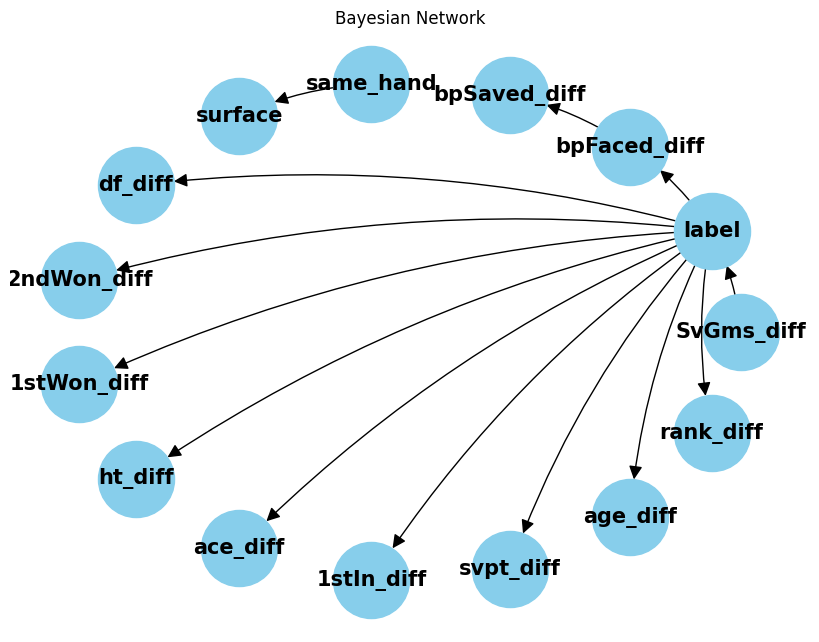

In [174]:
plt.figure(figsize=(8, 6))
pos = nx.circular_layout(model)
nx.draw(model, pos, with_labels=True, node_color='skyblue', node_size=3000, arrowsize=20, font_size=15, font_weight='bold', connectionstyle='arc3, rad = 0.1')
plt.title("Bayesian Network")
plt.show()

In [219]:
X_val = validation.drop(['label'], axis=1).reset_index(drop=True)
y_val = validation['label'].reset_index(drop=True)

In [242]:
y_pred = model.predict(X_val[:400], n_jobs=1)

100%|██████████| 400/400 [00:03<00:00, 122.73it/s]


In [243]:
print(metrics.classification_report(y_val[:400], y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       215
         1.0       1.00      1.00      1.00       185

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



In [244]:
print(metrics.confusion_matrix(y_val[:400], y_pred))

[[215   0]
 [  0 185]]
